In [70]:
#@title File upload and Stock selection
#@markdown You can run this cell which will display options to upload the file and select desired stocks to analyse
#@markdown After selecting desired stocks, press update and run later cells. Press Add Stock to add more stocks.
import re
import numpy as np
import pandas as pd
import seaborn as sns
from string import digits
from google.colab import files
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import datetime
import os
#from google.colab import data_table
#data_table.enable_dataframe_formatter()
import functools

plt.rcParams["figure.figsize"] = [12, 7]

class stocks_class:
  ss_i = 0
  stocks_selectors = []
  df = pd.DataFrame()
  df_filtered = pd.DataFrame()
  stocks_df = pd.DataFrame()
  stockdf = pd.DataFrame()
  stock_options = []
  options = []
  most_traded = []
  highest_cumulatives = []
  highest_differentials = []
  worst_differentials = []
  safest = []
  best_differentials = []

  fname = ''
  dsel=''
  i_start = 0
  i_end = 10

  def __init__(self):
    try:
      self.df = pd.read_csv(self.fname)
    except:
      uploaded = files.upload()
      try:
        fname = list(uploaded.keys())[0]
      except:
        fname = 'closed_positions_rt.csv'
      self.df = pd.read_csv(fname)
    ss_i = 0

    self.df['idxdate'] = pd.to_datetime(self.df['entrydate'], utc=True).dt.strftime("%y%m%d%H%M%S").astype(int)
    self.df.sort_values('idxdate', inplace=True)
    self.df.set_index('idxdate', inplace=True)

    #clean_symbols = lambda x: x.translate(str.maketrans('','',digits))
    clean_symbols = lambda x: re.search(r"[a-z]*", x, re.IGNORECASE).group()
    self.df['cleaned_symbols'] = self.df['symbol'].apply(clean_symbols)
    self.options = self.df.cleaned_symbols.unique()
    self.options.sort()
    """
    self.options = np.append('Best',self.options)
    self.options = np.append('Worst',self.options)
    self.options = np.append('Safest',self.options)
    self.options = np.append('Most Impactful',self.options)
    self.options = np.append('Most Traded',self.options)
    """
    self.options = np.append('None',self.options)

    self.df['E_Dates'] = pd.to_datetime(self.df['entrydate'], utc=True).dt.date
    #d_options = df.entrydate
    d_options = self.df.E_Dates.unique()
    self.d_sel = widgets.SelectionRangeSlider(options=d_options, index=(0, len(d_options)-1), description='Period: ', layout={"width": "900px"}, disabled=False)
    #s_sel=widgets.SelectionSlider(options=list(range(1,min(len(options),10))), value=1, description='Stocks', disabled=False, continuous_update=False, layout={"width": "600px"}, readout=True)
    print('Please select period to analyse')
    display(self.d_sel)
    print('Stocks to analyse: ')
    #display(s_sel)

    self.stocks_selectors += [widgets.Dropdown( options=self.options[1:], value=self.options[1], description=f'Stock {self.ss_i+1}:', disabled=False)]
    display(self.stocks_selectors[self.ss_i])
    self.ss_i += 1
  def add_stock(self):
    self.stocks_selectors += [widgets.Dropdown( options=self.options, value=self.options[0], description=f'Stock {self.ss_i+1}:', disabled=False)]
    display(self.stocks_selectors[self.ss_i])
    self.ss_i += 1
    plt.clf()
    plt.close()
  def update(self):
    self.stock_options = []
    self.df_filtered = pd.DataFrame()
    self.stockdf = pd.DataFrame()
    for selector in stock_obj.stocks_selectors:
      if selector.value == 'None':
        pass
      else:
        self.stock_options += [selector.value]
      """
      elif selector.value == 'Best':
        self.stock_options += self.best_differentials.tolist()
      elif selector.value == 'Worst':
        self.stock_options += self.worst_differentials.tolist()
      elif selector.value == 'Safest':
        self.stock_options += self.safest.tolist()
      elif selector.value == 'Most Traded':
        self.stock_options += self.most_traded
      elif selector.value == 'Most Impactful':
        self.stock_options += self.highest_cumulatives.tolist()
      """
    self.stock_options = list(dict.fromkeys(self.stock_options))
    #i_start, i_end = np.where(df.entrydate == d_sel.value[0])[0][0], np.where(df.entrydate == d_sel.value[1])[0][0]
    i_start, i_end = np.where(self.df.E_Dates == self.d_sel.value[0])[0][0], np.where(self.df.E_Dates == self.d_sel.value[1])[0][-1]
    self.df_filtered = self.df.iloc[i_start:i_end].copy()
    self.df_filtered = self.df_filtered[self.df_filtered['cleaned_symbols'].isin(self.stock_options)]

    self.df_filtered['time-in-trade'] = (pd.to_datetime(self.df_filtered['closedate'], utc=True)-pd.to_datetime(self.df_filtered['entrydate'], utc=True)).astype('timedelta64[s]')  

    self.df_filtered['C_Dates'] = pd.to_datetime(self.df_filtered['closedate'], utc=True).dt.date
    self.df_filtered['C_Time'] = pd.to_datetime(self.df_filtered['closedate'], utc=True).dt.time
    self.df_filtered['H'] = pd.to_datetime(self.df_filtered['entrydate'], utc=True).dt.strftime("%H").astype(int)
    self.df_filtered['D'] = pd.to_datetime(self.df_filtered['entrydate'], utc=True).dt.strftime("%d").astype(int)
    self.df_filtered['M'] = pd.to_datetime(self.df_filtered['entrydate'], utc=True).dt.strftime("%m").astype(int)
    self.df_filtered['day'] = pd.to_datetime(self.df_filtered['entrydate'], utc=True).dt.day_name()
    self.df_filtered['cm_realized'] = self.df_filtered.realizedpnl.cumsum()
    self.df_filtered['cm_true'] = self.df_filtered.realizedpnl

    self.most_traded = self.df['cleaned_symbols'].value_counts().reset_index()['index'].iloc[0:6].to_numpy()
    _diff_counts = stock_obj.df.groupby('cleaned_symbols')['realizedpnl'].sum().sort_values().reset_index()
    self.highest_cumulatives = np.concatenate([ _diff_counts['cleaned_symbols'].iloc[:2].to_numpy(), _diff_counts['cleaned_symbols'].iloc[-2:].to_numpy() ])
    counts = stock_obj.df.groupby('cleaned_symbols')['realizedpnl'].min().sort_values().reset_index()
    self.worst_differentials = counts['cleaned_symbols'].iloc[:2].to_numpy()
    self.safest = counts['cleaned_symbols'].iloc[-4:].to_numpy()

    counts = stock_obj.df.groupby('cleaned_symbols')['realizedpnl'].max().sort_values().reset_index()
    self.best_differentials = counts['cleaned_symbols'].iloc[-2:].to_numpy()

    self.df_filtered.set_index('closedate', inplace=True)

    ppnls = self.df_filtered[' percent_pnl']
    self.df_filtered['binned_ppnl'] = pd.cut(x=ppnls, bins=[-1, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 1],
                        labels=[-.30,-0.15, -0.075, -0.025, 0.025, 0.075, 0.15,0.30]).astype(float)
                        #labels=['<-20%','-20% to -10%', '-10% to -05%', '-05% to 0%', '0% to 05%', '05% to 10%', '10% to 20%','>20%'])

    #number of rows
    rows = len(self.df_filtered.index)
    stocks = self.df_filtered.cleaned_symbols.unique()
    #self.stockdf = self.df_filtered.set_index('C_Dates').filter(['C_Date','cm_realized'], axis=1)
    self.stockdf = self.df_filtered.filter(['closedate','cm_realized'], axis=1)
    for stk in stocks:
      self.stockdf[stk] = [ (rpnl if sym==stk else 0) for rpnl, sym in zip(self.df_filtered['realizedpnl'], self.df_filtered['cleaned_symbols']) ]
      self.stockdf[stk] = self.stockdf[stk].cumsum()
    #stockdf.index.name
    self.stockdf.rename_axis('Stocks', axis=1,inplace=True)
  def plot_lines(self):
    plt.figure(figsize=(12,12))
    g = sns.lineplot(data=self.stockdf)
    g.set(xticklabels=[])
    plt.legend(loc = 2, bbox_to_anchor = (1,1), framealpha=1, frameon=True)
    plt.xticks(rotation=45)
    plt.locator_params(axis='x', nbins=6)
  def plot_bars(self):
    ax = self.stockdf[self.stockdf.columns[1:]].plot(kind="bar", stacked=True, rot=45)
    self.stockdf[self.stockdf.columns[0]].plot(kind="line", ax=ax)
    plt.xticks(rotation=45)
    #plt.xticks(
    #rotation=45,
    #horizontalalignment='right',
    #fontweight='light',
    #fontsize='medium',
    #)
    plt.locator_params(axis='x', nbins=6)
  def plot_box(self):
    # Draw Plot
    plt.figure(figsize=(13,10), dpi= 80)
    sns.boxplot(x='cleaned_symbols', y='realizedpnl', data=self.df_filtered, notch=False)

    # Add N Obs inside boxplot (optional)
    def add_n_obs(df,group_col,y):
        medians_dict = {grp[0]:grp[1][y].median() for grp in self.df.groupby(group_col)}
        xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
        n_obs = self.df.groupby(group_col)[y].size().values
        #for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        #    plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

    add_n_obs(self.df_filtered,group_col='cleaned_symbols',y='realizedpnl')    

    # Decoration
    plt.title('Trades Overview', fontsize=22)
    #plt.ylim(-10, 40)
    plt.show()


button = widgets.Button(description="Add Stock")
output = widgets.Output()
display(button, output)

button1 = widgets.Button(description="Update")
output1 = widgets.Output()
display(button1, output1)

button2 = widgets.Button(description="Plot")
output2 = widgets.Output()
display(button2, output2)

def fun(rs):
  rs.add_stock()

def update(rs):
  rs.update()

def pllt(rs):
  rs.plot_lines()
  rs.plot_bars()

def on_button_clicked(b, rr):
    fun(rr)

def on_button_clicked1(b, rr):
    update(rr)

def on_button_clicked2(b, rr):
    pllt(rr)

stock_obj=stocks_class()
button.on_click(functools.partial(on_button_clicked, rr=stock_obj))
button1.on_click(functools.partial(on_button_clicked1, rr=stock_obj))
button2.on_click(functools.partial(on_button_clicked2, rr=stock_obj))



Button(description='Add Stock', style=ButtonStyle())

Output()

Button(description='Update', style=ButtonStyle())

Output()

Button(description='Plot', style=ButtonStyle())

Output()

Please select period to analyse


SelectionRangeSlider(description='Period: ', index=(0, 179), layout=Layout(width='900px'), options=(datetime.d…

Stocks to analyse: 


Dropdown(description='Stock 1:', options=('AA', 'AAPL', 'ABBV', 'ABCL', 'ABNB', 'ABUS', 'ABVC', 'ADBE', 'AEI',…

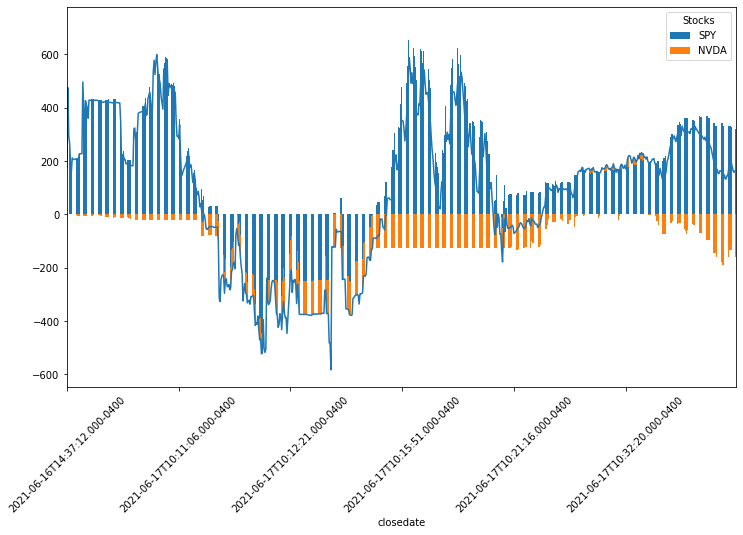

In [65]:
stock_obj.update()
stock_obj.plot_bars()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


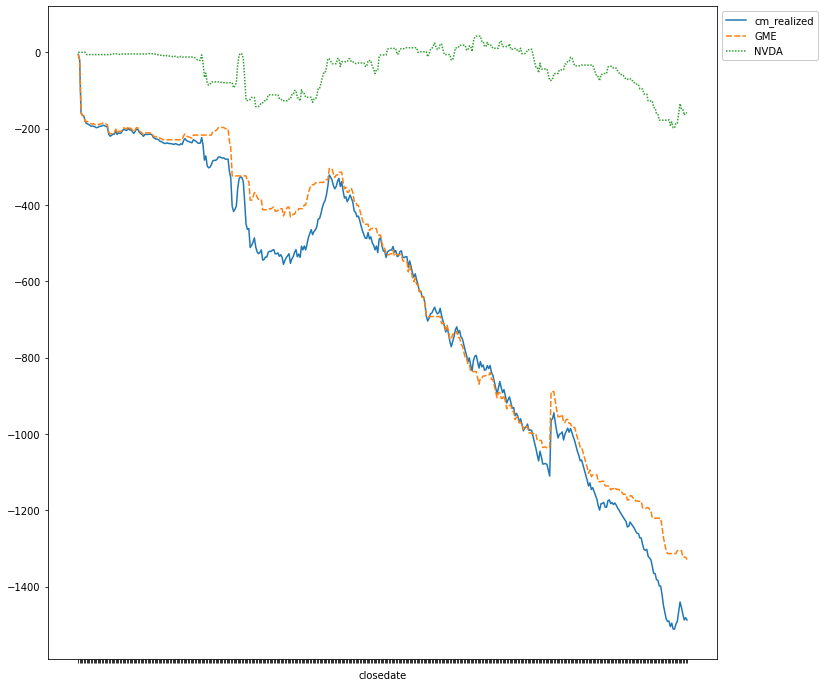

In [69]:
stock_obj.plot_lines()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


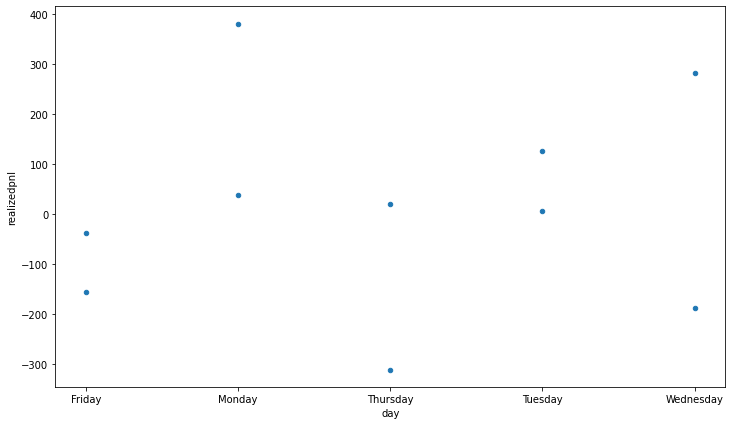

In [64]:
grp = stock_obj.df_filtered.groupby(['day','cleaned_symbols'])['cleaned_symbols','day','realizedpnl'].sum()
grp = grp.reset_index()
grp.plot(kind='scatter',x='day', y='realizedpnl')

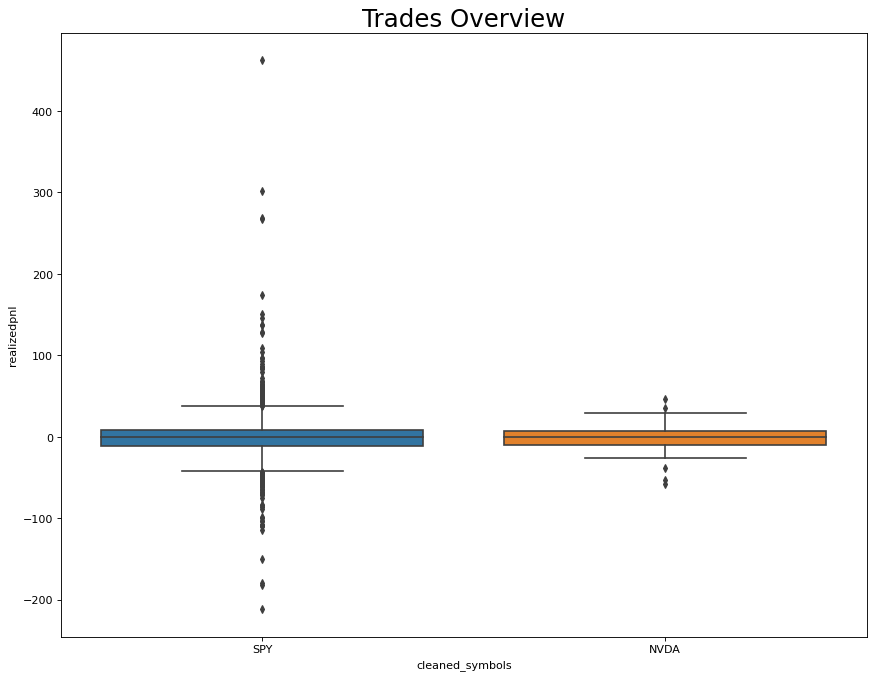

In [66]:
stock_obj.update()
stock_obj.plot_box()